In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.99"
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
from utils import *
import flax.linen as nn
from datasets import load_dataset
from tqdm import tqdm

import sys
sys.path.append('..')

import set_rcParams

d_model = 256
d_hidden = 256

n_samples = 2048
batch_size = 16

seed = 0

/home/nicolas/Identification-linear-systems-with-RNNs/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from transformers import AutoTokenizer, AutoModel
import torch


if not os.path.exists("data/bert_wiki_embeddings.npy"):
    # Load a pretrained model and tokenizer from Hugging Face
    model_name = "bert-base-uncased"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name, output_hidden_states=True)

    # Load a dataset
    dataset = load_dataset("wikipedia", "20220301.en", split="train")

    # Tokenize and encode the dataset
    def tokenize_function(examples):
        return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=512)

    # Select only the first `num_examples` from the dataset
    subset_dataset = dataset.select(range(n_samples))

    # Apply the tokenizer to the subset dataset
    tokenized_dataset = subset_dataset.map(tokenize_function, batched=True)

    # Extract embeddings
    def extract_embeddings(batch):
        inputs = {k: batch[k] for k, v in batch.items() if k in tokenizer.model_input_names}
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings = outputs.hidden_states[0].numpy()  # Mean pooling to get a single vector per example
        return {"embeddings": embeddings}

    # Apply the embedding extraction
    tokenized_dataset.set_format(type="torch", columns=tokenizer.model_input_names)
    embeddings_dataset = tokenized_dataset.map(extract_embeddings, batched=True, batch_size=8)

    # Convert to a format suitable for further processing, if needed
    inputs = np.array(embeddings_dataset["embeddings"])

    np.save("data/bert_wiki_embeddings.npy", inputs)

else:
    inputs = np.load("data/bert_wiki_embeddings.npy")

### Correlation input

In [3]:
# compute autocorrelation of x[batch, time, feature]
# autocorr(Delta) = E_(batch, time, feature) [x(t) * x(t + Delta)]
def corr(x, lag):
    return np.mean(x[:, lag:] * x[:, :-lag])

correlations = [np.mean(inputs**2)] + [corr(inputs, lag) for lag in range(1, inputs.shape[1]-1)]

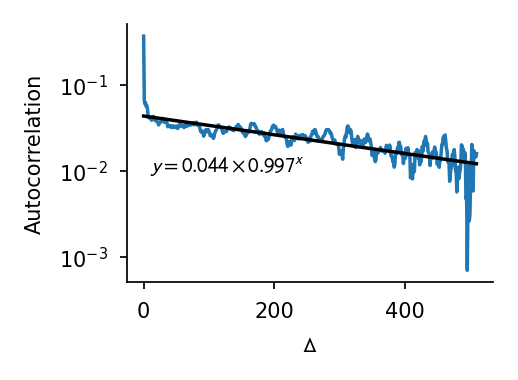

In [4]:
# fit affine line on log correlations 
plt.figure(figsize=(1.9, 1.35))
plt.plot(correlations, c="#1F77B4")
x = np.arange(len(correlations))
y = np.log10(correlations)
A = np.vstack([x, np.ones(len(x))]).T
m, c = np.linalg.lstsq(A, y, rcond=None)[0]
plt.plot(np.power(10, m * x + c), c="black")
plt.yscale("log")
plt.ylabel("Autocorrelation")
plt.xlabel("$\Delta$")
plt.text(10, 0.01, fr"$y = {np.power(10, c):.3f} \times {np.power(10, m):.3f}^x$", fontsize=6)
plt.minorticks_off()
plt.tight_layout(pad=0.1)

### Architecture

In [5]:
def chrono_init(key, shape, dtype=jnp.float32, T_min=1, T_max=None):
    return jnp.log(jax.random.uniform(key, shape, dtype=dtype, minval=T_min, maxval=T_max))

class ChronoGRUCell(nn.RNNCellBase):
    features: int
    T_min: float = 1.0
    T_max: float = 10.0
    scale_h: float = 1.
    scale_x: float = 1.
    simple_version: bool = False

    @nn.compact
    def __call__(self, carry, inputs):
        h = carry
        hidden_features = h.shape[-1]
        # input and recurrent layers are summed so only one needs a bias.
        dense_h = partial(
            nn.Dense,
            features=hidden_features,
            use_bias=False,
            kernel_init=nn.initializers.orthogonal(scale=self.scale_h),
        )
        dense_i = partial(
            nn.Dense,
            features=hidden_features,
            use_bias=True,
            kernel_init=nn.initializers.variance_scaling(2 * self.scale_x, "fan_in", "normal")
        )
        dense_ir = dense_i(name="ir")
        if self.T_min is None or self.T_max is None:
            dense_iz = dense_i(name="iz")  # default init
        else:
            dense_iz = dense_i(
                bias_init=partial(chrono_init, T_min=self.T_min, T_max=self.T_max), name="iz"
            )
        r = nn.sigmoid(dense_ir(inputs) + dense_h(name="hr")(h))
        z = nn.sigmoid(dense_iz(inputs) + dense_h(name="hz")(h))
        # add bias because the linear transformations aren't directly summed.
        if self.simple_version:
            n = nn.Dense(hidden_features, name="in", use_bias=False)(inputs)
        else:
            n = nn.tanh(dense_i(name="in")(inputs) + r * dense_h(name="hn", use_bias=True)(h))

        new_h = (1.0 - z) * n + z * h
        return new_h, new_h

    @nn.nowrap
    def initialize_carry(self, rng, input_shape):
        batch_dims = input_shape[:-1]
        mem_shape = batch_dims + (self.features,)
        return nn.initializers.zeros_init()(rng, mem_shape, jnp.float32)

    
class RNN(nn.Module):
    d_hidden: int
    cell_type: type = ChronoGRUCell
    T_min: float = 1.0
    T_max: float = 10.0
    scale_h: float = 1.
    scale_x: float = 1.
    simple_version: bool = False

    @nn.compact
    def __call__(self, x, carry=None):
        ScanRNN = nn.scan(
            self.cell_type,
            variable_broadcast="params",
            split_rngs={"params": False},
            in_axes=1,
            out_axes=1,
        )

        rnn = ScanRNN(
            features=self.d_hidden, T_min=self.T_min, T_max=self.T_max, scale_h=self.scale_h, scale_x=self.scale_x, simple_version=self.simple_version
        )
        input_shape = x.shape[:2]
        if carry is None:
            carry = rnn.initialize_carry(jax.random.PRNGKey(0), input_shape)
        carry, x = rnn(carry, x)
        return x


### Recurrent Jacobian

In [6]:
def plot_recurrent_jacobians(fig, ax, t_min, t_max, scale_h, scale_x, id_sample):
    rnn = partial(RNN, d_hidden=d_model, T_min=t_min, T_max=t_max, cell_type=ChronoGRUCell, scale_h=scale_h, scale_x=scale_x)()
    params = rnn.init(jax.random.PRNGKey(seed), inputs[id_sample:id_sample+1])

    def recurrent_jacobian(model, params, X, d_hidden, time):
        carry = jnp.zeros((1, d_hidden))
        f = lambda c: model.apply(params, X[id_sample:id_sample+1, :time], carry=c)[:, -1]
        return jax.jacobian(f)(carry)

    times = jnp.power(2, jnp.linspace(0, 9, 20)).astype(int)
    jacobians = []
    for t in times:
        jacobians.append(recurrent_jacobian(rnn, params, inputs, d_model, t)[:, :, 0])

    jacs = jnp.concatenate(jacobians)
    diag_terms_jacs = jnp.diagonal(jacs, axis1=1, axis2=2)
    non_diag_terms_jacs = (jacs - jax.vmap(jnp.diag)(diag_terms_jacs)).reshape(len(times), -1)
    indices = jax.random.choice(jax.random.PRNGKey(0), np.arange(len(inputs)), shape=(512,), replace=False)
    ax.plot(times, non_diag_terms_jacs[:, indices], c="grey", alpha=0.2);
    ax.plot(times, diag_terms_jacs, c="#1F77B4", alpha=0.2)
    ax.plot([], [], c="#1F77B4", alpha=1, label="Diagonal terms")
    ax.plot([], [], c="grey", alpha=1, label="Non-diagonal terms")
    ax.set_xscale("log")
    ax.set_xlabel(r"$\Delta t$")
    ax.set_ylabel(r"Entries of $\frac{\partial h_{\Delta t}}{\partial h_{0}}$")
    ax.minorticks_off()

CUDA backend failed to initialize: jaxlib/cuda/versions_helpers.cc:98: operation cuInit(0) failed: CUDA_ERROR_NO_DEVICE (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


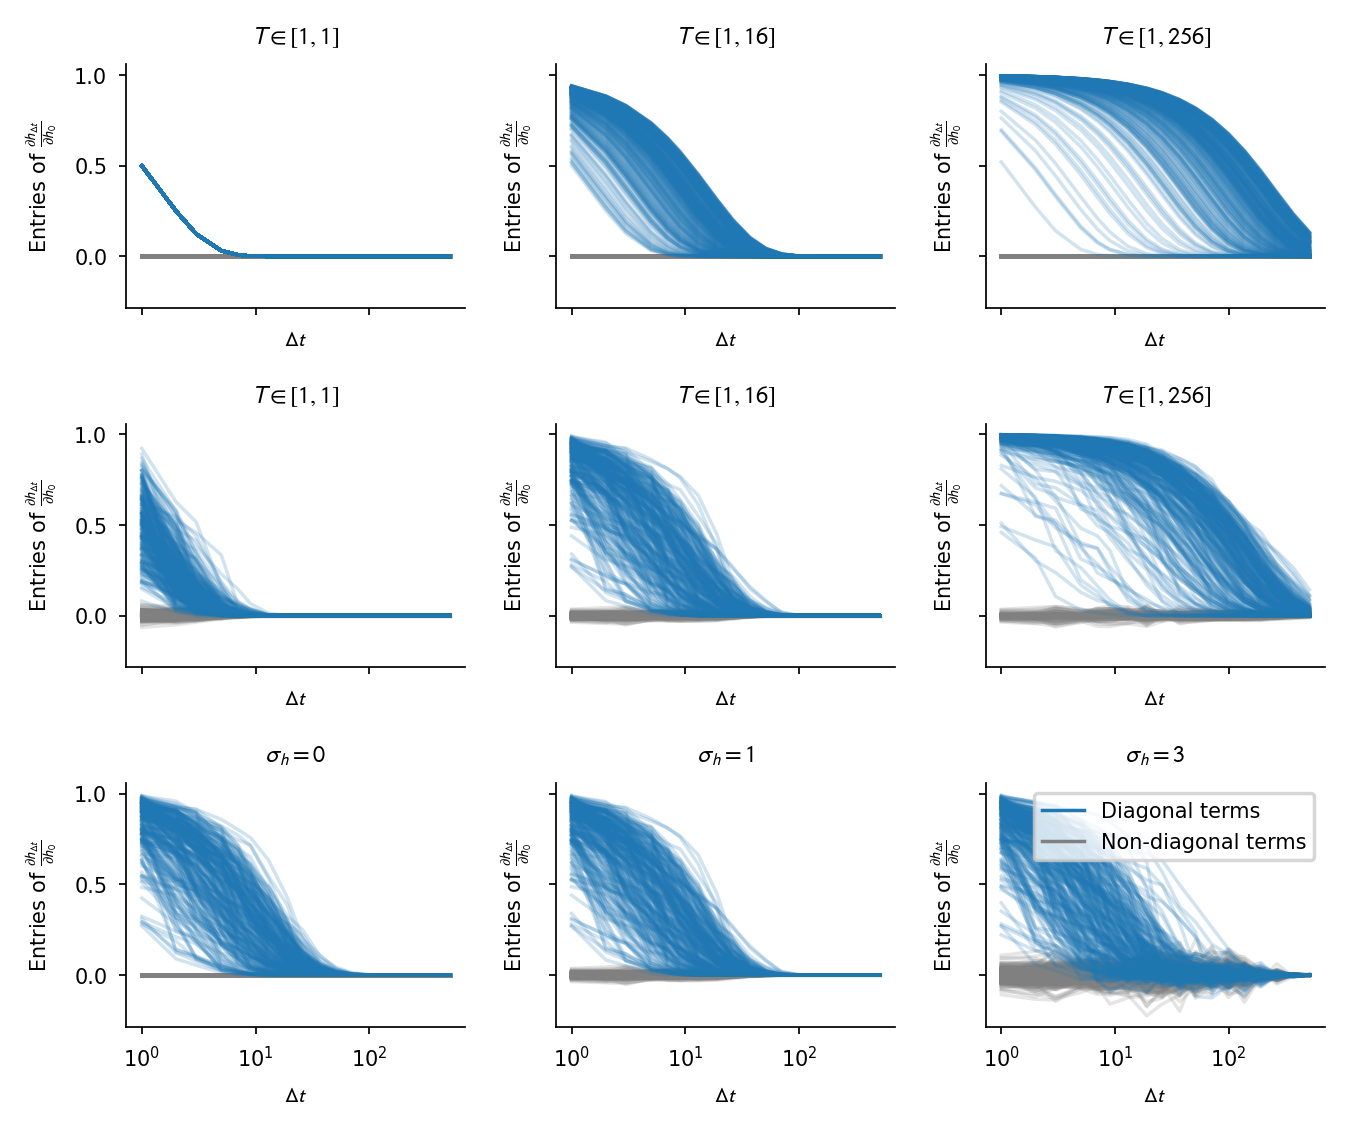

In [7]:
id_sample = 42
fig, ax = plt.subplots(3, 3, figsize=(5.6, 4.6), sharex=True, sharey=True)
plot_recurrent_jacobians(fig, ax[0][0], t_min=1.0, t_max=1.0, scale_h=0.0, id_sample=id_sample, scale_x=0)
plot_recurrent_jacobians(fig, ax[0][1], t_min=1.0, t_max=16, scale_h=0.0, id_sample=id_sample, scale_x=0)
plot_recurrent_jacobians(fig, ax[0][2], t_min=1.0, t_max=256, scale_h=0.0, id_sample=id_sample, scale_x=0)
plot_recurrent_jacobians(fig, ax[1][0], t_min=1.0, t_max=1.0, scale_h=1.0, id_sample=id_sample, scale_x=1)
plot_recurrent_jacobians(fig, ax[1][1], t_min=1.0, t_max=16, scale_h=1.0, id_sample=id_sample, scale_x=1)
plot_recurrent_jacobians(fig, ax[1][2], t_min=1.0, t_max=256, scale_h=1.0, id_sample=id_sample, scale_x=1)
plot_recurrent_jacobians(fig, ax[2][0], t_min=1.0, t_max=16, scale_h=0.0, id_sample=id_sample, scale_x=1)
plot_recurrent_jacobians(fig, ax[2][1], t_min=1.0, t_max=16, scale_h=1.0, id_sample=id_sample, scale_x=1)
plot_recurrent_jacobians(fig, ax[2][2], t_min=1.0, t_max=16, scale_h=3., id_sample=id_sample, scale_x=1)
ax[0][0].set_title(r"$T \in [1, 1]$", fontsize=7)
ax[0][1].set_title(r"$T \in [1, 16]$", fontsize=7)
ax[0][2].set_title(r"$T \in [1, 256]$", fontsize=7)
ax[1][0].set_title(r"$T \in [1, 1]$", fontsize=7)
ax[1][1].set_title(r"$T \in [1, 16]$", fontsize=7)
ax[1][2].set_title(r"$T \in [1, 256]$", fontsize=7)
ax[2][0].set_title(r"$\sigma_h = 0$", fontsize=7)
ax[2][1].set_title(r"$\sigma_h = 1$", fontsize=7)
ax[2][2].set_title(r"$\sigma_h = 3$", fontsize=7)
plt.legend()
plt.tight_layout(pad=1)

### Predict signal propagation

In [8]:
rho0_0 = 0.043056426671195004
rho0 = 0.9970052541497257
rho1_0 = 0.332
rho1 = 0.

def auxilliary(alpha, beta, rho_0, rho):
    return rho_0 * (1 - alpha) * (1 - beta) * (1 - (rho ** 2) * alpha * beta) / (1 - rho * alpha) / (1 - rho * beta) / (1 - alpha * beta)

def get_double_aux(rho0_0, rho0, rho1_0, rho1): 
    return lambda alpha, beta: auxilliary(alpha, beta, rho1_0, rho1) + auxilliary(alpha, beta, rho0_0, rho0)

def var_h(lamb):
    aux = get_double_aux(rho0_0, rho0, rho1_0, rho1)
    return aux(lamb, lamb)

def var_dh_dtheta(lamb):
    aux = get_double_aux(rho0_0, rho0, rho1_0, rho1)
    grad_aux = jax.grad(aux, argnums=0)
    sec_der = jax.grad(grad_aux, argnums=1)
    inv_sigmoid = lambda x: jnp.log(x / (1 - x))
    return (aux(lamb, lamb) + 2 * grad_aux(lamb, lamb) + sec_der(lamb, lamb)) * jax.grad(nn.sigmoid)(inv_sigmoid(lamb))**2

def conditional_mean(X, Y, x, beta=100):
    attention = jax.nn.softmax(-(X - x)**2 / beta) # (jnp.log(X) -jnp.log(x))**2 / beta)
    return jnp.dot(attention, Y) / jnp.sum(attention)

@partial(jax.jit, static_argnums=(0,))
def dh_dtheta(model, params, input):
    p = params.copy()
    def h(iz_bias):
        p["params"]["ScanChronoGRUCell_0"]["iz"]["bias"] = iz_bias
        return model.apply(p, input)[:, -1:]
    
    return h(jnp.copy(params["params"]["ScanChronoGRUCell_0"]["iz"]["bias"])), jax.jacobian(h)(jnp.copy(params["params"]["ScanChronoGRUCell_0"]["iz"]["bias"]))

In [9]:
all_b, all_h, all_dh = [], [], []
for scale_x, scale_h in [(0, 0), (1, 0), (1, 1)]:
    rnn = partial(RNN, d_hidden=d_model, T_min=1, T_max=256, cell_type=ChronoGRUCell, scale_x=scale_x, scale_h=scale_h, simple_version=True)()
    b, dh, h = [], [], []
    for id_sample in tqdm(range(100)):
        params = rnn.init(jax.random.PRNGKey(id_sample), inputs[id_sample:id_sample+1])

        bias = params["params"]["ScanChronoGRUCell_0"]["iz"]["bias"]
        last_hiddens, jacobians = dh_dtheta(rnn, params, inputs[id_sample:id_sample+1])
        diag_terms = jnp.diagonal(jacobians[0][0])
        b.append(bias)
        h.append(last_hiddens.reshape(-1))
        dh.append(diag_terms)
    all_b.append(b)
    all_dh.append(dh)
    all_h.append(h)

100%|██████████| 100/100 [05:14<00:00,  3.14s/it]


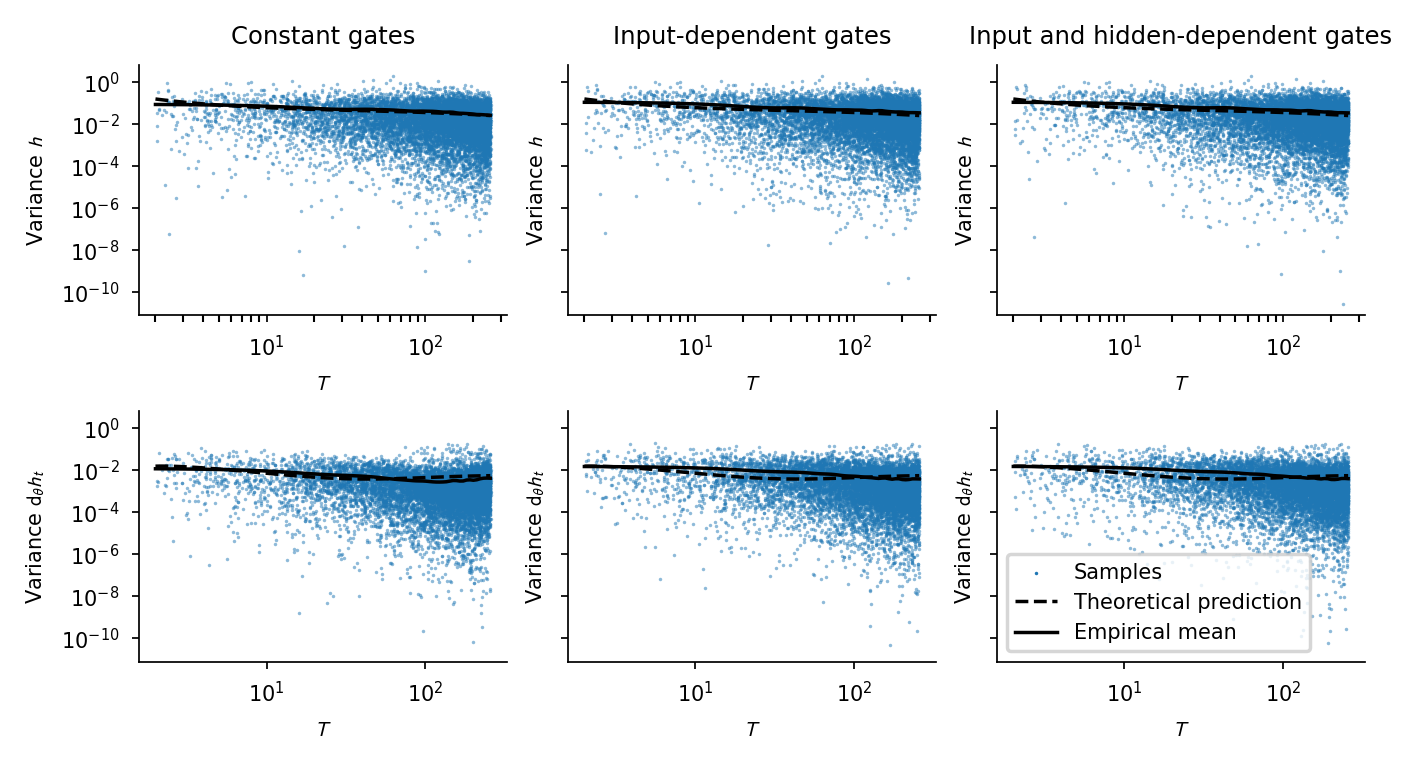

In [10]:
fig, ax = plt.subplots(2, 3, figsize=(5.5, 3), sharey=True)
titles = ["Constant gates", "Input-dependent gates", "Input and hidden-dependent gates"]
for i, (b, dh, h) in enumerate(zip(all_b, all_dh, all_h)):
    bs = jnp.concatenate(b)
    dhs = jnp.concatenate(dh)
    hs = jnp.concatenate(h)
    transf = lambda x: 1 / (1 - x)
    inv_transf = lambda x: 1 - 1 / x
    random_ids = jax.random.choice(jax.random.PRNGKey(0), np.arange(len(bs)), shape=(10000,), replace=False)
    Ts = jnp.power(10, jnp.linspace(jnp.log10(2), jnp.log10(256), 100))
    ax[0][i].set_title(titles[i], fontsize=7)
    ax[0][i].scatter(transf(nn.sigmoid(bs))[random_ids], hs[random_ids]**2, c="#1F77B4", s=1, alpha=0.5, linewidth=0)
    ax[0][i].scatter([], [], c="#1F77B4", label="Samples", s=1, linewidth=0)
    ax[0][i].plot(Ts, jax.vmap(var_h)(inv_transf(Ts)), c="black", ls="--", label="Theoretical prediction")
    ax[0][i].plot(Ts, jax.vmap(partial(conditional_mean, transf(nn.sigmoid(bs)), hs**2))(Ts), c="black", label="Empirical mean")
    ax[0][i].set_xscale("log")
    ax[0][i].set_xlabel(r"$T$")
    ax[0][i].set_yscale("log")
    ax[0][i].set_ylabel(r"Variance $h$")
    ax[1][i].scatter(transf(nn.sigmoid(bs))[random_ids], dhs[random_ids]**2, c="#1F77B4", s=1, alpha=0.5, linewidth=0)
    ax[1][i].scatter([], [], c="#1F77B4", label="Samples", s=1, linewidth=0)
    ax[1][i].plot(Ts, jax.vmap(var_dh_dtheta)(inv_transf(Ts)), c="black", ls="--", label="Theoretical prediction")
    ax[1][i].plot(Ts, jax.vmap(partial(conditional_mean, transf(nn.sigmoid(bs)), dhs**2))(Ts), c="black", label="Empirical mean")
    ax[1][i].set_xscale("log")
    ax[1][i].set_xlabel(r"$T$")
    ax[1][i].set_yscale("log")
    ax[1][i].set_ylabel(r"Variance $\mathrm{d}_\theta h_t$")
    ax[1][i].minorticks_off()
plt.legend()

plt.tight_layout(pad=0.5)